
# **Árbol de Regresión para la Predicción de Robos a Transeúntes**
### Problemática a resolver:
El objetivo es **predecir la cantidad de robos a transeúntes esperados en zonas específicas de la CDMX**, considerando el contexto espacial y temporal de los delitos. Esto busca ayudar en la planificación y asignación de recursos de seguridad en áreas de alta incidencia.

Para construir el modelo de Árbol de Regresión, se utilizarán variables relacionadas con la ubicación geográfica y el momento del delito: `mes_hecho`, `hora_hecho`, `alcaldia_hecho`, `fecha_hecho`, `latitud`, y `longitud`.
La variable objetivo es la **frecuencia de robos a transeúntes** por zona y periodo temporal, calculada a partir de la cantidad de incidentes registrados en el dataset.



### Información utilizada:
El análisis se basa en un conjunto de datos proporcionado por la Fiscalía General de Justicia de la CDMX, que contiene información detallada sobre delitos, con un enfoque en los robos a transeúntes.
A partir de este dataset, se seleccionaron y procesaron las siguientes variables clave:


### Diccionario de datos

| Número de variable | Nombre de la variable | Tipo de dato | Descripción |
|--------------------|-----------------------|--------------|-------------|
| 1                  | mes_hecho        | Categórico   | Mes codificado en el que ocurrió el delito, donde 0=enero y 11=diciembre. |
| 2                  | hora_hecho            | Continuo   | Hora exacta en la que ocurrió el hecho, en formato "HH". |
| 3                  | 	alcaldia_hecho        | Categórico   | Nombre de la Alcaldía donde ocurrió el hecho(texto). |
| 4                  | 	fecha_hecho               | Categórico     | Fecha exacta en la que ocurrió el hecho, en formato "DD/MM/AAAA". |
| 5                  | latitud               | Continuo     | Coordenada de latitud del lugar donde ocurrió el hecho. |
| 6                  | longitud              | Continuo     | Coordenada de longitud del lugar donde ocurrió el hecho. |

Para fines prácticos tomamos una muestra de 100 registros aleatorios de las siguientes alcaldías:

•	Iztapalapa

•	Cuauhtémoc

•	Gustavo A. Madero

•	Benito Juárez

•	Miguel Hidalgo

•	Álvaro Obregón

Esta muestra ya está limpia y no contiene valores nulos.

Nota: Las alcaldías fueron seleccionadas de esa manera porque son en las que ocurren más delitos e hicimos esa selección con el fin de delimitar los datos.


---



Carga de bibliotecas y librerías

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt


Carga de datos

In [ ]:
data = pd.read_csv("carpetasFGJ_acumulado_2024_01.csv")
#data = pd.read_csv("/content/carpetasFGJ_acumulado_2024_01.csv")

<ipython-input-4-388e33fd4b35>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("carpetasFGJ_acumulado_2024_01.csv")


In [ ]:
data.head(5)

,anio_inicio,mes_inicio,fecha_inicio,hora_inicio,anio_hecho,mes_hecho,fecha_hecho,hora_hecho,delito,categoria_delito,...,fiscalia,agencia,unidad_investigacion,colonia_hecho,colonia_catalogo,alcaldia_hecho,alcaldia_catalogo,municipio_hecho,latitud,longitud
0,2016,Enero,2016-01-01,00:00:00,2015.0,Diciembre,2015-12-31,16:30:00,LESIONES CULPOSAS POR TRANSITO VEHICULAR EN CO...,DELITO DE BAJO IMPACTO,...,INVESTIGACIÓN EN TLALPAN,TLP-4,UI-2CD,JARDINES EN LA MONTAÑA,Jardines En La Montaña,TLALPAN,Tlalpan,CDMX,19.30086,-99.20877
1,2016,Enero,2016-01-01,00:00:00,2015.0,Diciembre,2015-12-31,22:40:00,ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA,ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA,...,INVESTIGACIÓN EN TLALPAN,TLP-1,UI-2CD,LOMAS DE PADIERNA,Lomas De Padierna,TLALPAN,Tlalpan,CDMX,19.29003,-99.21748
2,2016,Enero,2016-01-01,00:00:00,2016.0,Enero,2016-01-01,00:20:00,ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...,...,INVESTIGACIÓN EN IZTAPALAPA,IZP-2,UI-2CD,SAN ANTONIO CULHUACÁN,Barrio San Antonio Culhuacan,IZTAPALAPA,Iztapalapa,CDMX,19.34080,-99.11431
3,2016,Enero,2016-01-01,00:00:00,2015.0,Diciembre,2015-12-31,22:00:00,ROBO DE VEHICULO DE SERVICIO PARTICULAR SIN VI...,ROBO DE VEHÍCULO CON Y SIN VIOLENCIA,...,INVESTIGACIÓN EN GUSTAVO A. MADERO,GAM-8,UI-2CD,SAN JUAN DE ARAGÓN II SECCIÓN,San Juan De Aragon Ii Seccion,GUSTAVO A. MADERO,Gustavo A. Madero,CDMX,19.45106,-99.08669
4,2016,Enero,2016-01-01,00:00:00,2015.0,Diciembre,2015-12-31,22:30:00,HOMICIDIOS INTENCIONALES (OTROS),HOMICIDIO DOLOSO,...,INVESTIGACIÓN EN BENITO JUÁREZ,BJ-1,UI-2SD,NATIVITAS,Nativitas,BENITO JUAREZ,Benito Juárez,CDMX,19.38095,-99.13982


##Variables seleccionadas
Para el árbol de regresión utilizaremos las siguientes variables:

latitud: ubicación geográfica de los delitos.

longitud: ubicación geográfica de los delitos.

dia_semana: para conocer los días específicos en los que ocurren los delitos, donde 0=lunes y 6=domingo

mes_codificado: para ver cuales meses presentan un mayor número de delitos, donde 0=enero y así sucesivamente hasta 11=diciembre.

hora_minutos: con esta variable podemos conocer los delitos en función del tiempo transcurrido en minutos.

alcaldia_codificada: con esta variable podemos conocer la zona específica de la ciudad, donde 0=Alvaro Obregon, 1=Benito Juarez, 2= Cuahtemoc, 3=Gustavo A. Madero, 4=Iztapalapa, 5=Miguel Hidalgo.


conteo_delitos: variable objetivo.

In [ ]:
data = data[data['delito'].str.contains("ROBO.*TRANSEUNTE", case=False, na=False)]
data['fecha_hecho'] = pd.to_datetime(data['fecha_hecho'], errors='coerce')
data['dia_semana'] = data['fecha_hecho'].dt.weekday + 1
data = data[data['alcaldia_hecho'].isin(['IZTAPALAPA', 'CUAUHTEMOC', 'GUSTAVO A. MADERO', 'BENITO JUAREZ', 'MIGUEL HIDALGO', 'ALVARO OBREGON'])]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91328 entries, 2 to 1867361
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   mes_hecho            91314 non-null  object        
 1   hora_hecho           91314 non-null  object        
 2   fecha_hecho          91314 non-null  datetime64[ns]
 3   alcaldia_hecho       91328 non-null  object        
 4   latitud              90968 non-null  float64       
 5   longitud             90968 non-null  float64       
 6   delito               91328 non-null  object        
 7   dia_semana           91314 non-null  float64       
 8   mes_codificado       91328 non-null  int64         
 9   alcaldia_codificada  91328 non-null  int64         
 10  delito_codificada    91328 non-null  int64         
 11  hora_minutos         91314 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(3), object(4)
memory usage: 11.1+ MB


### Transformación de variables categóricas

Aqui codificaremos las columnas "mes_hecho" y "alcaldia_hecho". También haremos al conversion de "hora_hecho"

In [ ]:
df = data
label_encoder_mes = LabelEncoder()
df['mes_codificado'] = label_encoder_mes.fit_transform(df['mes_hecho'])

label_encoder_alcaldia = LabelEncoder()
df['alcaldia_codificada'] = label_encoder_alcaldia.fit_transform(df['alcaldia_hecho'])

df['hora_minutos'] = pd.to_datetime(df['hora_hecho'], format='%H:%M:%S').dt.hour * 60 + pd.to_datetime(df['hora_hecho'], format='%H:%M:%S').dt.minute


Aqui realizamos un conteo de delitos por alcaldía y mes en el DataFrame y despues lo agregamos en una nueva columna llamada "conteo_delitos".

In [ ]:
conteo_delitos = df.groupby(['alcaldia_hecho', 'mes_hecho']).size().reset_index(name='conteoDelitos')

df = df.merge(conteo_delitos, on=['alcaldia_hecho', 'mes_hecho'], how='left')

##Seleccion de 100 muestras

In [ ]:
df = df.dropna()

num_per_alcaldia = 100 // df['alcaldia_hecho'].nunique()

muestra = df.groupby('alcaldia_hecho', group_keys=False).apply(lambda x: x.sample(min(len(x), num_per_alcaldia)))

if len(muestra) < 100:
    missing_count = 100 - len(muestra)
    extra_samples = df[~df.index.isin(muestra.index)].sample(missing_count)
    muestra = pd.concat([muestra, extra_samples])
print(muestra['alcaldia_hecho'].value_counts())
print(f"Tamaño de la muestra: {muestra.shape}")

alcaldia_hecho
BENITO JUAREZ        18
ALVARO OBREGON       17
GUSTAVO A. MADERO    17
CUAUHTEMOC           16
IZTAPALAPA           16
MIGUEL HIDALGO       16
Name: count, dtype: int64
Tamaño de la muestra: (100, 13)


<ipython-input-104-788e1adfe274>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  muestra = df.groupby('alcaldia_hecho', group_keys=False).apply(lambda x: x.sample(min(len(x), num_per_alcaldia)))


In [ ]:
muestra

,mes_hecho,hora_hecho,fecha_hecho,alcaldia_hecho,latitud,longitud,delito,dia_semana,mes_codificado,alcaldia_codificada,delito_codificada,hora_minutos,conteoDelitos
36842,Julio,10:16:00,2018-07-27,ALVARO OBREGON,19.377430,-99.211750,ROBO A TRANSEUNTE DE CELULAR CON VIOLENCIA,5.0,5,0,3,616.0,740.0
42412,Noviembre,20:20:00,2018-11-12,ALVARO OBREGON,19.370960,-99.234500,ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA,1.0,9,0,13,1220.0,791.0
81293,Septiembre,16:00:00,2022-09-21,ALVARO OBREGON,19.397838,-99.208119,ROBO A TRANSEUNTE EN VIA PUBLICA SIN VIOLENCIA,3.0,11,0,14,960.0,753.0
75107,Diciembre,05:30:00,2021-12-29,ALVARO OBREGON,19.347630,-99.222040,ROBO A TRANSEUNTE EN VIA PUBLICA SIN VIOLENCIA,3.0,2,0,14,330.0,916.0
36402,Julio,14:20:00,2018-07-31,ALVARO OBREGON,19.348210,-99.226380,ROBO A TRANSEUNTE DE CELULAR SIN VIOLENCIA,2.0,5,0,4,860.0,740.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27665,Enero,10:00:00,2018-01-23,MIGUEL HIDALGO,19.432510,-99.172400,ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA,2.0,3,5,13,600.0,891.0
61530,Mayo,00:20:00,2020-05-28,BENITO JUAREZ,19.388960,-99.168890,ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA,4.0,8,1,13,20.0,861.0
55798,Octubre,15:30:00,2019-10-09,ALVARO OBREGON,19.385280,-99.226670,ROBO A TRANSEUNTE EN RESTAURANT CON VIOLENCIA,3.0,10,0,9,930.0,802.0
67994,Marzo,13:20:00,2021-03-19,GUSTAVO A. MADERO,19.470250,-99.091910,ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA,5.0,7,3,13,800.0,1070.0


In [ ]:
muestra.to_csv("Datos_Arbol.csv", index=False)

In [ ]:
muestra.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 68355 to 16818
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   mes_hecho            100 non-null    object        
 1   hora_hecho           100 non-null    object        
 2   fecha_hecho          100 non-null    datetime64[ns]
 3   alcaldia_hecho       100 non-null    object        
 4   latitud              100 non-null    float64       
 5   longitud             100 non-null    float64       
 6   delito               100 non-null    object        
 7   dia_semana           100 non-null    float64       
 8   mes_codificado       100 non-null    int64         
 9   alcaldia_codificada  100 non-null    int64         
 10  delito_codificada    100 non-null    int64         
 11  hora_minutos         100 non-null    float64       
 12  conteoDelitos        100 non-null    float64       
dtypes: datetime64[ns](1), float64(5), 

## Modelo

### Definición de variables

In [ ]:
X = muestra[['latitud', 'longitud','dia_semana', 'mes_codificado', 'hora_minutos', 'alcaldia_codificada']]
y = muestra['conteoDelitos']

In [ ]:
X.head()

,latitud,longitud,dia_semana,mes_codificado,hora_minutos,alcaldia_codificada
79906,19.354409,-99.175223,7.0,5,420.0,0
59869,19.325660,-99.257320,2.0,7,1170.0,0
82982,19.355887,-99.198785,2.0,2,810.0,0
8022,19.363440,-99.195340,5.0,10,1070.0,0
24649,19.364120,-99.243570,2.0,2,1230.0,0


In [ ]:
print(y)

3562      807.0
51344     807.0
77893     754.0
60847     754.0
74813     916.0
          ...  
75340     891.0
14386    1673.0
666      1974.0
11635     812.0
618      1938.0
Name: conteoDelitos, Length: 100, dtype: float64


### División de conjunto de entrenamiento y de prueba

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(y_train)

35133     974.0
36155     854.0
21726     962.0
4040     1886.0
51020    2005.0
          ...  
58850    1048.0
83783    2124.0
1866      772.0
46451     896.0
35103    1046.0
Name: conteoDelitos, Length: 80, dtype: float64


Escalamiento

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
print(X_train)

         latitud   longitud  dia_semana  mes_codificado  hora_minutos  \
35133  19.495370 -99.119780         6.0               6         480.0   
36155  19.442670 -99.196170         4.0               5        1290.0   
21726  19.394690 -99.166530         6.0              10         290.0   
4040   19.432950 -99.147700         5.0               6        1230.0   
51020  19.365230 -99.005210         3.0               8         990.0   
...          ...        ...         ...             ...           ...   
58850  19.479090 -99.141020         7.0               4         420.0   
83783  19.391391 -99.048062         7.0               3         949.0   
1866   19.387300 -99.211380         2.0               7        1330.0   
46451  19.441540 -99.176980         5.0               2        1380.0   
35103  19.538300 -99.147530         3.0               5         660.0   

       alcaldia_codificada  
35133                    3  
36155                    5  
21726                    1  
4040   

### Entrenar modelo

In [ ]:
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train_scaled, y_train)

DecisionTreeRegressor(random_state=42)

### Predicción

In [ ]:
y_pred = model.predict(X_test_scaled)
y_pred

array([ 854., 1048., 2059., 2321., 1673., 2321.,  829.,  896.,  802.,
        802.,  829.,  825., 2025., 2275.,  896.,  916., 2025., 2124.,
        916.,  916.])

<ipython-input-48-8a31eaa984ed>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')


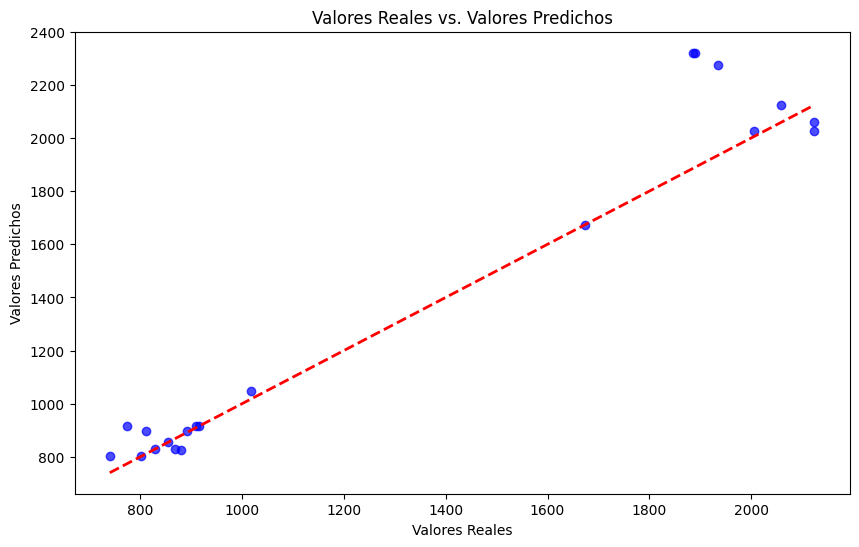

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.title("Valores Reales vs. Valores Predichos")
plt.show()


Como podemos ver en la grafica la mayoría de los puntos están bastante cerca de la línea roja, esto sugiere que el modelo tiene un buen desempeño.

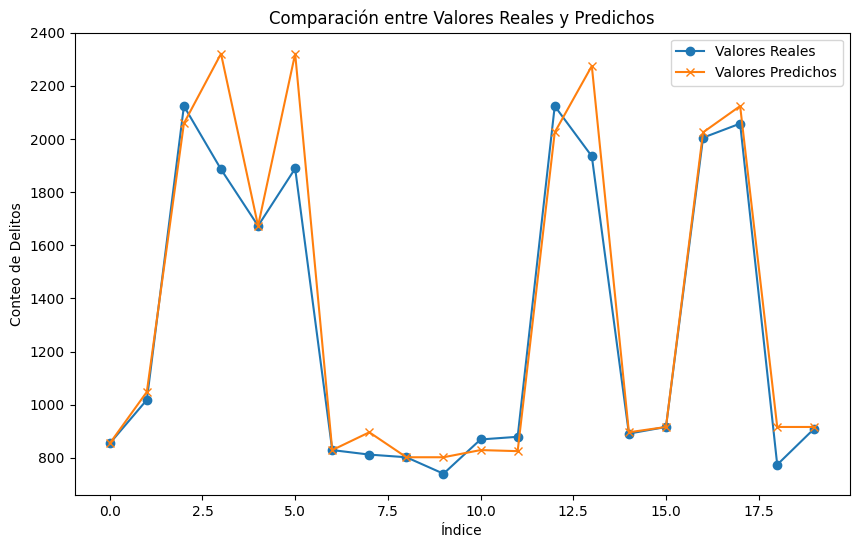

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="Valores Reales", marker='o')
plt.plot(y_pred, label="Valores Predichos", marker='x')
plt.xlabel("Índice")
plt.ylabel("Conteo de Delitos")
plt.title("Comparación entre Valores Reales y Predichos")
plt.legend()
plt.show()

Como podemos observar en la gráfica, el modelo sigue la tendencia general de los valores reales. No obstante, existen pequeños errores en la magnitud de algunos puntos.

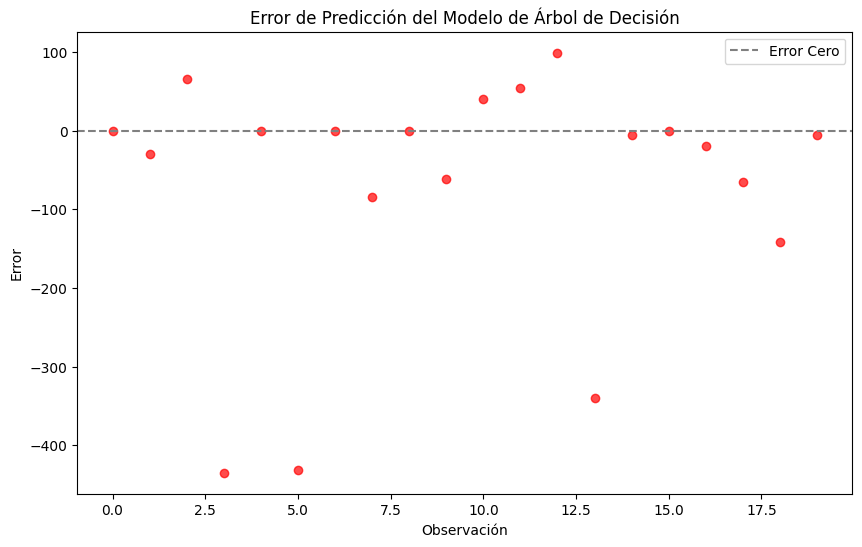

In [ ]:
error = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), error, color='red', alpha=0.7)
plt.axhline(y=0, color='gray', linestyle='--', label="Error Cero")
plt.title('Error de Predicción del Modelo de Árbol de Decisión')
plt.xlabel('Observación')
plt.ylabel('Error')
plt.legend()
plt.show()

En este gráfico de errores, podemos notar en la observación 7 que el punto está bastante alejado de la línea de error, esto indica una gran diferencia entre el valor real y el predicho.

Por otro lado, en la observación 10, la predicción fue mucho más precisa, ya que, el punto correspondiente a esta observación está muy cerca de la línea de error 0, indicando que el modelo se aproximó bastante al valor real en este caso.


In [ ]:
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

# Calcular el RMSE
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

MSE: 27338.6
RMSE: 165.3438840719547
R-squared: 0.9099036691055659


Con el 0.90 del R^2 podemos decir que el modelo es capaz de realizar predicciones razonablemente precisas. Aunque el RMSE de 165.34 indica que el modelo tiene un margen de error que podría reducirse.

# Regularización
## Sin CV
### Parámetros
*   max_depth: Limita la profundidad máxima del árbol, ayudando a evitar el sobreajuste.
*   min_samples_split: Define el número mínimo de muestras necesarias para dividir un nodo.
*   min_samples_leaf: Define el número mínimo de muestras que debe tener una hoja, lo cual evita que el árbol crezca demasiado.
*   max_leaf_nodes: Limita el número máximo de hojas en el árbol.

In [ ]:
model = DecisionTreeRegressor(random_state=42, max_depth=10, min_samples_split=5, min_samples_leaf=3)
model.fit(X_train_scaled, y_train)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=3, min_samples_split=5,
                      random_state=42)

### Predicción

In [ ]:
y_pred = model.predict(X_test_scaled)
y_pred

array([ 877.5       , 1068.        , 2079.4       , 2079.4       ,
       1876.        , 2213.33333333,  840.66666667,  894.33333333,
        804.75      ,  804.75      ,  840.66666667,  834.75      ,
       2079.4       , 1876.        ,  894.33333333,  916.        ,
       2079.4       , 2079.4       ,  916.        ,  916.        ])

In [ ]:
print(y_test)

18266     854.0
33332    1018.0
75573    2124.0
62054    1886.0
30582    1673.0
1756     1889.0
16781     829.0
67304     812.0
7202      802.0
79906     740.0
46320     869.0
53610     879.0
75681    2124.0
6285     1935.0
58534     891.0
24649     916.0
33299    2005.0
35610    2058.0
84691     774.0
25697     910.0
Name: conteoDelitos, dtype: float64


<ipython-input-72-93662cb4cc7a>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')


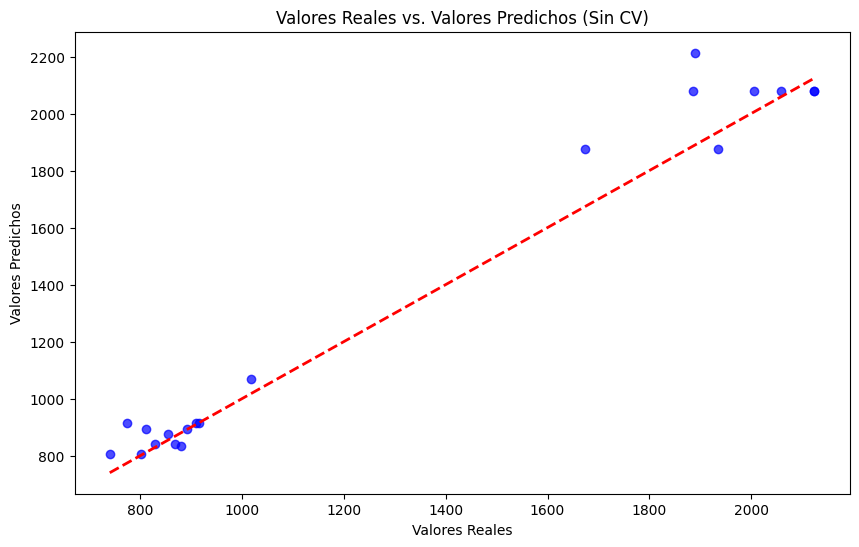

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.title("Valores Reales vs. Valores Predichos (Sin CV)")
plt.show()

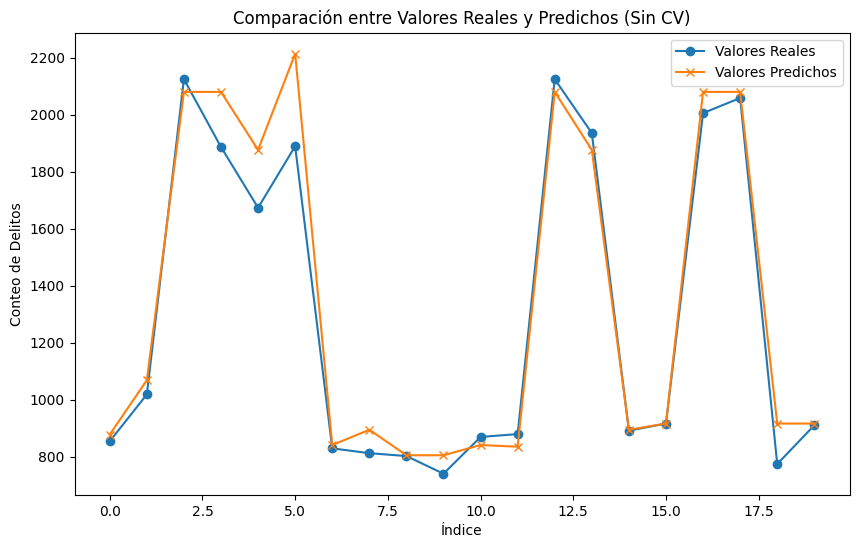

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="Valores Reales", marker='o')
plt.plot(y_pred, label="Valores Predichos", marker='x')
plt.xlabel("Índice")
plt.ylabel("Conteo de Delitos")
plt.title("Comparación entre Valores Reales y Predichos (Sin CV)")
plt.legend()
plt.show()

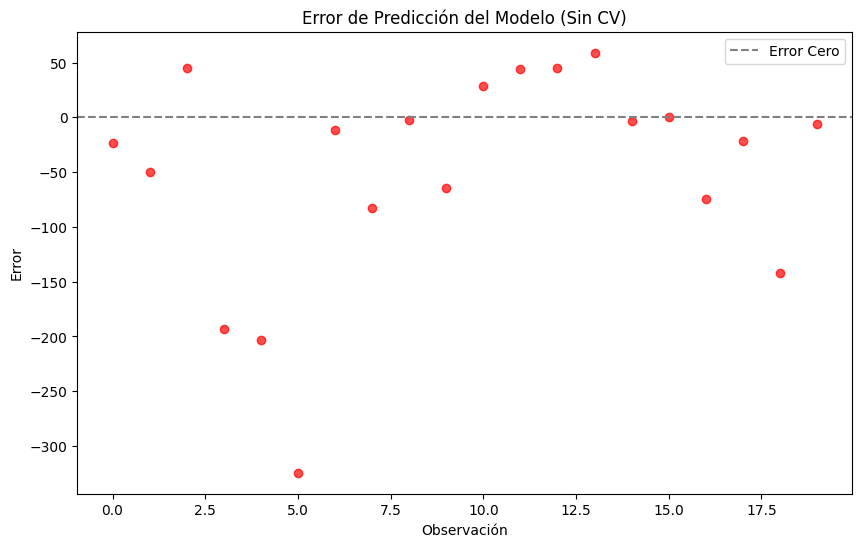

In [ ]:
error = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), error, color='red', alpha=0.7)
plt.axhline(y=0, color='gray', linestyle='--', label="Error Cero")
plt.title('Error de Predicción del Modelo (Sin CV)')
plt.xlabel('Observación')
plt.ylabel('Error')
plt.legend()
plt.show()

In [ ]:
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

MSE: 11719.826319444452
RMSE: 108.25814666547942
R-squared: 0.9613764658723576


Esta fue la mejor configuración a la que llegamos para obtener un RMSE de 108.258

## Con CV

In [ ]:
param_grid = {
    'max_depth': [5, 10, 15, 20, 25, 30, None],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 3, 5, 10, 15],
    'max_leaf_nodes': [None, 10, 20, 30, 40, 50]
}

In [ ]:
model = DecisionTreeRegressor(random_state=42)


In [ ]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [5, 10, 15, 20, 25, 30, None],
                         'max_leaf_nodes': [None, 10, 20, 30, 40, 50],
                         'min_samples_leaf': [1, 3, 5, 10, 15],
                         'min_samples_split': [2, 5, 10, 15, 20]},
             scoring='neg_mean_squared_error')

In [ ]:
mejorModelo = DecisionTreeRegressor(max_depth=5, max_leaf_nodes=20, random_state=42)
mejorModelo.fit(X_train_scaled, y_train)

DecisionTreeRegressor(max_depth=5, max_leaf_nodes=20, random_state=42)

In [ ]:
y_pred_mejor = mejorModelo.predict(X_test_scaled)

<ipython-input-86-07ba1fd4dcb3>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')


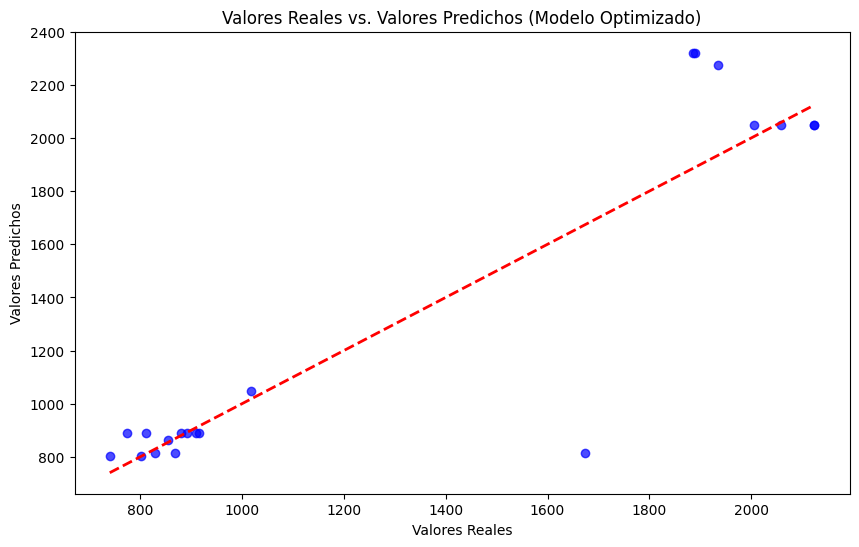

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_mejor, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.title("Valores Reales vs. Valores Predichos (Modelo Optimizado)")
plt.show()

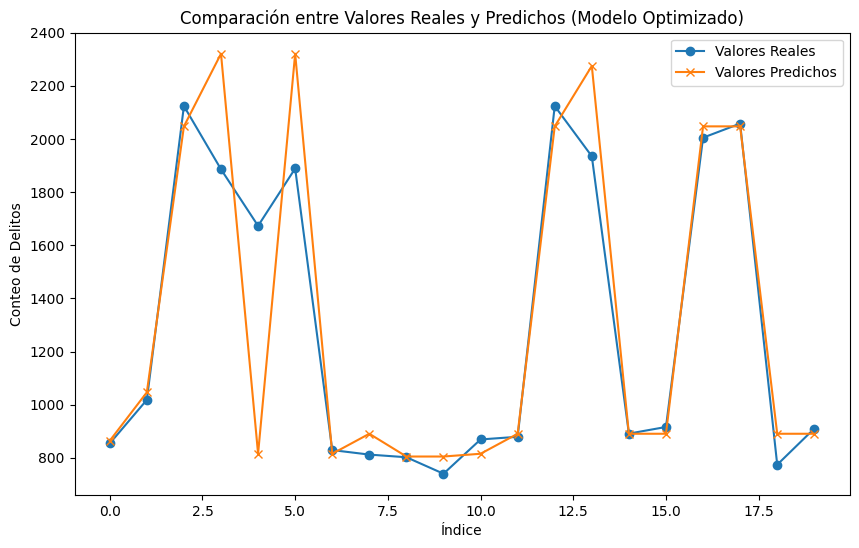

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="Valores Reales", marker='o')
plt.plot(y_pred_mejor, label="Valores Predichos", marker='x')
plt.xlabel("Índice")
plt.ylabel("Conteo de Delitos")
plt.title("Comparación entre Valores Reales y Predichos (Modelo Optimizado)")
plt.legend()
plt.show()


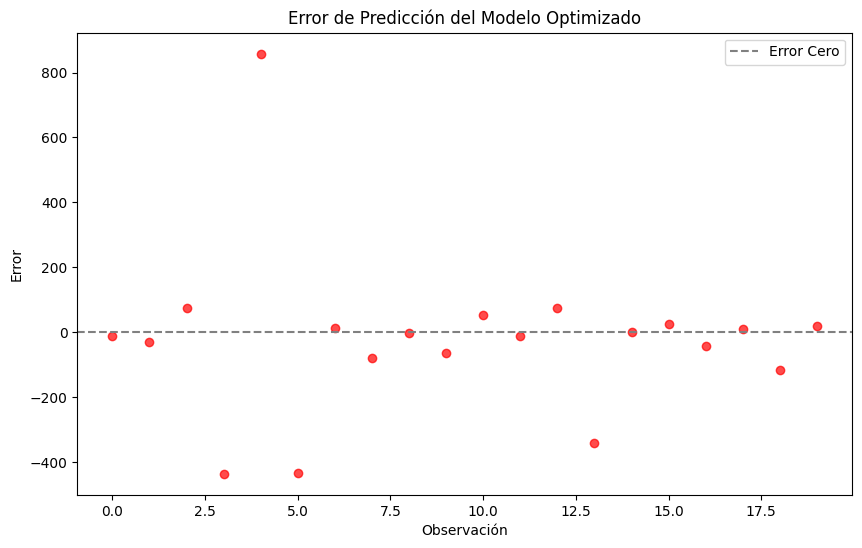

In [ ]:

error_best = y_test - y_pred_mejor
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), error_best, color='red', alpha=0.7)
plt.axhline(y=0, color='gray', linestyle='--', label="Error Cero")
plt.title('Error de Predicción del Modelo Optimizado')
plt.xlabel('Observación')
plt.ylabel('Error')
plt.legend()
plt.show()

In [ ]:
mse_best = mean_squared_error(y_test, y_pred_mejor)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test, y_pred_mejor)
print("MSE: ", mse_best)
print("RMSE: ", rmse_best)
print("R-squared: ", r2_best)

MSE:  63500.57364817687
RMSE:  251.9932015911875
R-squared:  0.7907292730647317


Como pudimos observar dismuyó el desempeño del modelo. Esto puede ser efecto de usar la validación cruzada en el proceso de selección de hiperparámetros, ya que, el modelo se entrena y evalúa en diferentes subconjuntos de los datos, lo que puede afectar la selección de los hiperparámetros y así prioriza la generalización sobre el ajuste específico.